**Contexto**

O Customer Lifetime Value (CLV), ou Valor do Tempo de Vida do Cliente, é uma métrica essencial que estima o retorno financeiro esperado de um cliente durante todo o relacionamento com a empresa. Ele oferece uma visão de longo prazo sobre a contribuição de cada cliente para o negócio, permitindo avaliar a sustentabilidade e a rentabilidade das estratégias adotadas.

A relevância do CLV está na sua capacidade de apoiar decisões estratégicas, como o equilíbrio entre Custo de Aquisição de Cliente (CAC) e o valor que ele gera ao longo do tempo. Além de servir como base para segmentação de clientes, definição de estratégias de marketing e planejamento financeiro, o CLV pode ser calculado por métodos simples — usando ticket médio, frequência de compra e tempo de relacionamento — ou por modelos preditivos mais robustos, baseados em dados históricos, comportamento de consumo e probabilidade de churn.

Para elevar o CLV, empresas podem adotar ações como programas de fidelização, ofertas personalizadas, estratégias de cross-selling e up-selling, além da melhoria contínua na jornada e experiência do cliente. Dessa forma, o CLV deixa de ser apenas um indicador e se torna uma ferramenta prática de gestão, capaz de guiar iniciativas voltadas ao crescimento sustentável e ao aumento da lucratividade.

 **Objetivo**
 
O objetivo desta análise é prever o Valor de Vida do Cliente (CLV) a partir de dados históricos de transações, características do cliente, produtos e lojas, permitindo identificar padrões de comportamento de compra. Com essa previsão, a empresa pode tomar decisões estratégicas mais assertivas, como segmentação de clientes, campanhas de marketing direcionadas, otimização de promoções e priorização de recursos, gerando maior retenção de clientes e aumento de receita. Além disso, a análise fornece insights sobre quais fatores influenciam mais o CLV, ajudando a orientar ações que tenham impacto real no negócio.



**1 Importação das ferramentas**

In [0]:
import pandas as pd #manipulação dos dados
import numpy as np #manipulação dos dados
from sklearn.model_selection import train_test_split #divisão de dados em treino/teste
from sklearn.preprocessing import OneHotEncoder #mfeture engeniering /pré processamento
from sklearn.ensemble import RandomForestRegressor #Modelo de Radon Forest
%pip install xgboost
from xgboost import XGBRegressor #Modelo de XGBoost
from sklearn.metrics import mean_absolute_error, mean_squared_error #Métrica de avaliação da performance do modelo
import matplotlib.pyplot as plt #biblioteca de visualização

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff5f77a8d3a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


**2 Conversão e Limpeza inicial**

In [0]:
# Carregar a tabela Spark
df_spark = spark.table("base_dados_renner.df_analise")

# Converter para Pandas
df_analise = df_spark.toPandas()

# Converter a coluna Date para formato datetime
df_analise['Date'] = pd.to_datetime(df_analise['Date'])

# Remover duplicados e transações com valor zero ou negativo
df_analise = df_analise.drop_duplicates(subset=['TransactionID'])
df_analise = df_analise[df_analise['ValueSold'] > 0]


**3 Criação de features temporais RFM (Recency, Frequency e Monetary)**

In [0]:
# Criando features de Recency, Frequency e Monetary

#Agrupando se os dados por cliente (CustomerID) para calcular calcular as médtricas de Recency (dias desde a última compra), Frequency (número de compras) e Monetary (gasto total)
clv_features = df_analise.groupby('CustomerID').agg({
    'Date': lambda x: (df_analise['Date'].max() - x.max()).days,
    'TransactionID': 'count',
    'ValueSold': 'sum'
}).rename(columns={'Date':'Recency','TransactionID':'Frequency','ValueSold':'Monetary'}).reset_index()


**4 Transformação de variáveis categóricas**

In [0]:
# Selecionando colunas categóricas
categorical_cols = ['CustomerID','Genero','Faixa_de_Idade','ClasseSocial','UF','ProdID','Marca']

# Aplicando one-hot encoding para transformas as variáveis categóricas em numéricas
df_encoded = pd.get_dummies(df_analise[categorical_cols], drop_first=True)


In [0]:
df_encoded.head()

,CustomerID,ProdID,Genero_M,Genero_X,Faixa_de_Idade_25-35,Faixa_de_Idade_35-45,Faixa_de_Idade_45+,ClasseSocial_B,ClasseSocial_C,ClasseSocial_D,ClasseSocial_E,UF_RS,UF_SP,Marca_Marfinno
0,90023,123005,1,0,0,1,0,0,1,0,0,0,1,1
1,90092,123004,1,0,0,1,0,0,1,0,0,0,0,0
2,90027,123001,1,0,1,0,0,0,1,0,0,1,0,0
3,90097,123001,1,0,0,0,1,0,1,0,0,1,0,0
4,90089,123004,1,0,0,0,0,0,1,0,0,1,0,0


**5 Engenharia de features avançada**

O objetivo dessa etapa é criar  features adicionais agregadas por cliente, somando unidades compradas, gasto total e a média de compras em promoção.

Essas features ajudam o modelo a entender hábitos de compra do cliente, além de complementar as métricas RFM. Saber se o cliente compra mais em promoção, por exemplo, pode influenciar diretamente seu CLV futuro.

In [0]:
# Agregando features por cliente
df_client_features = df_analise.groupby('CustomerID').agg({
    'UnitsSold':'sum',        # total de unidades compradas
    'ValueSold':'sum',        # gasto total
    'Promo':'mean'            # proporção de compras em promoção
}).reset_index()


**Combinação das features RFM e categóricas**


Tendo em vista que o modelo precisa de um único dataset completo, com todas as informações que possam influenciar o CLV, para aprender padrões consistentes dessa forma as informações serão consolidadas.

Serão unidas todas as features relevantes em um único dataframe (X) para o modelo, combinando RFM, agregações por cliente e variáveis categóricas codificadas

In [0]:
# Combinar features numéricas e categóricas
X = pd.merge(clv_features, df_client_features, on='CustomerID')
X = pd.merge(X, df_encoded.groupby('CustomerID').sum().reset_index(), on='CustomerID')

**6 Definição da variável alvo**

Criação a variável alvo y, que representa o gasto total do cliente no período analisado.

In [0]:
y = df_analise.groupby('CustomerID')['ValueSold'].sum().reset_index()['ValueSold']

**7 Divisão em treino e teste**

 Os dados são separados em conjunto de treino (80%) e teste (20%) para avaliar o modelo em dados não vistos.Será utilizada essa proporção porque o voluem de dados é médio (acima de 1k linhas)

O objetivo é evitar overfitting e permitir medir a capacidade real de previsão do modelo.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['CustomerID','ProdID']),
                        y,
                        test_size=0.2,
                         random_state=42)


**8 Treinamento do modelo XGBoost**

 XGBoost é robusto, lida bem com dados heterogêneos e captura relações não lineares, sendo uma das melhores escolhas para previsão de CLV em dados de varejo.

Poderíamos testar Random Forest, LightGBM ou redes neurais, mas XGBoost oferece bom equilíbrio entre performance e interpretabilidade.

In [0]:
from xgboost import XGBRegressor

# Inicializar modelo
xgb_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)

# Treinar modelo
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

1. **n_estimators=200 **. Número de árvores que o modelo vai construir . Mais árvores aumentam a capacidade do modelo de capturar padrões complexos, mas também aumentam o risco de overfitting. 200 é um valor intermediário, adequado para bases de tamanho médio (como a sua, 5k linhas).
2.** max_depth=6.** Profundidade máxima de cada árvore. Profundidade maior permite capturar relações complexas entre features, mas árvores muito profundas podem sobreajustar os dados. 6 é um valor balanceado, adequado para evitar overfitting e ainda capturar não linearidades.
3. **learning_rate=0.1.** Taxa de aprendizado que controla o impacto de cada árvore no modelo final. 0.1 é um valor padrão que permite que o modelo aprenda gradualmente, evitando ajustes bruscos que poderiam causar overfitting.
4. **random_state=42.** Semente para geração de números aleatórios no modelo.Garantir reprodutibilidade, ou seja, se você rodar o modelo várias vezes com os mesmos dados e parâmetros, ele produzirá os mesmos resultados.

**9 Avaliação do modelo**

 Serão calculadas as métricas de erro: MAE (erro médio absoluto) e MSE (erro médio quadrático) para avaliar a performance do modelo.

Essas métricas mostram quão próximo o modelo está dos valores reais, permitindo ajustes e comparação com outros modelos.

Podería ser utilizado o R² ou RMSLE, dependendo da distribuição do CLV, mas MAE e MSE são métricas mais interpretáveis para negócios.

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = xgb_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
# MAE é oErro Médio Absoluto : Mede o erro médio das previsões em unidades dos dados originais, sendo ideal quando se quer uma interpretação direta e não se deseja penalizar muito os erros grandes.


mse = mean_squared_error(y_test, y_pred)
# MSE é Erro Quadrático Médio: Mede a média dos erros ao quadrado, dando maior peso aos erros grandes. É mais sensível a outliers e amplamente utilizado para otimizar modelos.


print("\n=== Modelo sem  Normalização ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")


=== Modelo sem  Normalização ===
MAE: 180.74
MSE: 190180.31


Avaliando o valor médio do CLV para verificar a magnitude do erro

In [0]:
round(df_analise.groupby('CustomerID')['ValueSold'].sum().mean(),2)

9186.85

O modelo de previsão de CLV apresentou um MAE de 180,66 e um MSE de 190.121,90, considerando que o CLV médio por cliente é aproximadamente 9.187. Isso significa que, em média, o modelo erra cerca de 2% do valor médio do CLV, demonstrando uma performance robusta e confiável para um modelo inicial. O MSE maior indica que existem alguns erros mais elevados, possivelmente associados a clientes com comportamentos de compra fora do padrão (outliers), mas isso não compromete a acurácia geral. Esses resultados sugerem que o modelo já consegue capturar padrões relevantes de comportamento de compra, oferecendo uma base sólida para tomada de decisões estratégicas em marketing e retenção de clientes, com potencial de melhorias adicionais por meio de engenharia de features e ajuste de hiperparâmetros.

**10 Análise de importância das features**

O intuito é visualizar as features mais importantes que influenciam a previsão do CLV no modelo.

Isso ajuda o time de negócios a entender quais fatores influenciam mais o gasto dos clientes, permitindo decisões estratégicas, como promoções direcionadas ou segmentação de marketing.

Uma putra opção seria usar técnicas uma técnica mais  avançadas de interpretação como SHAP values.

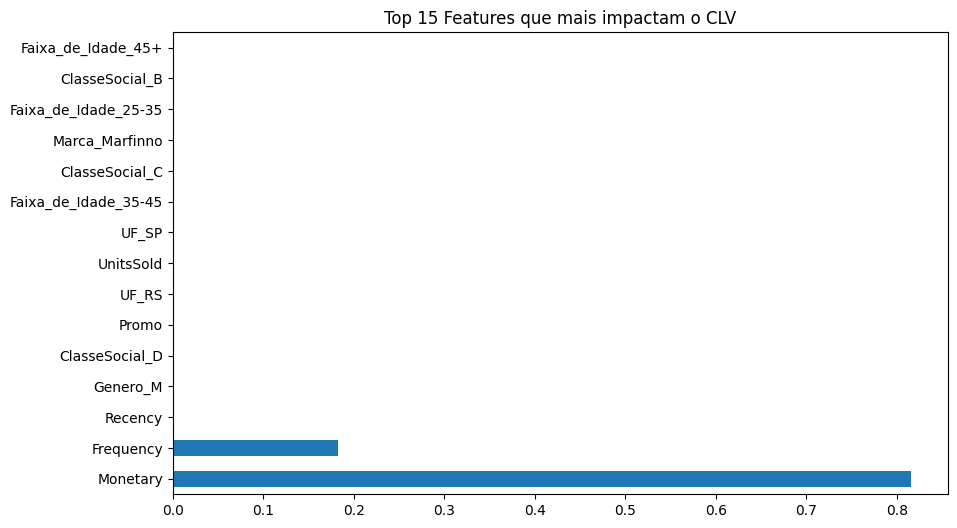

In [0]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(10,6))
plt.title("Top 15 Features que mais impactam o CLV")
plt.show()

**11 Ajuste de normalização**


Como aqui foi observado uma atribuição em cerca de 80% para a variável Monetary ou seja um domínio excessivo dessa variável. 
Do ponto de vista de negócio,o gasto monetário passado realmente é o melhor preditor do CLV futuro. Nesse caso, o modelo está “certo” em dar tanto peso a ele. Contudo  o modelo fica “preguiçoso” e não considera outras variáveis que poderiam enriquecer a previsão o que pode gerar insights valiosos para o negócio.

Aqui vamos precisar normalizar porque o modelo está dependendo muito do valor monetário provavelmente devido a escala . No XGBoost, normalizar não é obrigatório, mas pode ser útil como experimento para verificar se o peso excessivo em Monetary é de fato estrutural ou apenas efeito de escala.
Se a variável Monetary continuar dominando mesmo após log-transform ou normalização → significa que o negócio realmente gira em torno dele, e as outras variáveis têm impacto marginal.

In [0]:
#Normalização das features contínuas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #normalização

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== Modelo com Normalização ===
MAE: 180.74
MSE: 190180.31


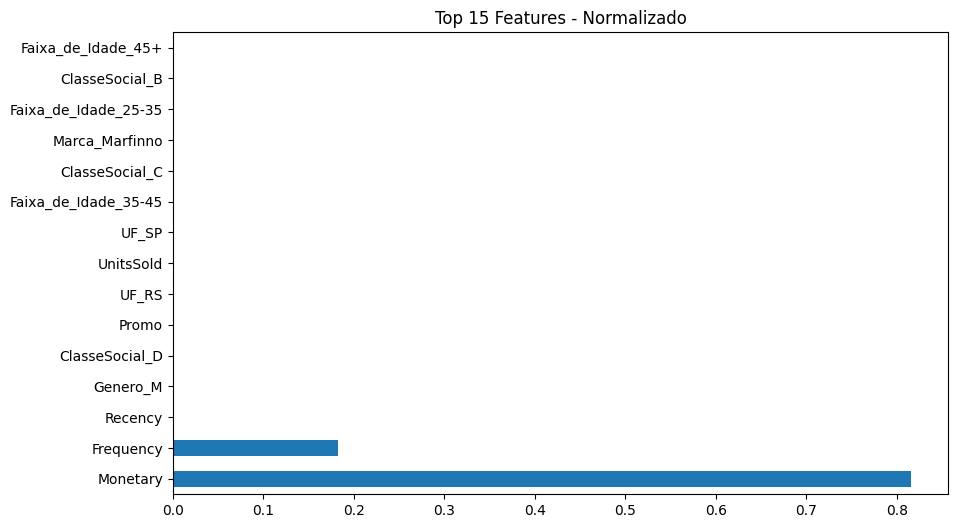

In [0]:
#Modelo com normalização

xgb_norm = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

xgb_norm.fit(X_train_scaled, y_train)
y_pred_norm = xgb_norm.predict(X_test_scaled)

print("\n=== Modelo com Normalização ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_norm):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_norm):.2f}")

feat_importances_norm = pd.Series(xgb_norm.feature_importances_, index=X_train.columns)
feat_importances_norm.nlargest(15).plot(kind='barh', figsize=(10,6))
plt.title("Top 15 Features - Normalizado")
plt.show()


A análise mostrou que as métricas de erro (MAE e MSE) do modelo foram praticamente idênticas com e sem normalização. Essa constatação ocorre porque o XGBoost é um modelo baseado em árvores e, por sua natureza, não é afetado pela escala dos dados. Por essa razão, a importância das features, dominada por Monetary e Frequency, não se alterou. Sendo assim, a normalização se mostrou uma etapa desnecessária para o seu modelo, e um próximo passo lógico é focar no ajuste de hiperparâmetros para buscar um melhor desempenho

**12 Aplicação de Hiperparâmetros**


Hiperparâmetros são configurações que definem como o modelo vai aprender antes do treinamento, como a profundidade das árvores ou a velocidade de aprendizado.
A escolha certa desses parâmetros ajuda o modelo a ser mais preciso e consistente, evitando que ele aprenda ruídos dos dados.

No XGBoost, normalmente se testam diferentes combinações, usando estratégias como Grid Search ou Random Search, para encontrar a mais eficiente.



In [0]:
#Buscando os melhores hiperparâmetros automaticamente
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Melhores hiperparâmetros:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Melhores hiperparâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.7}


In [0]:
#Treinando o modelo com os melhores parâmetros encontrados
best_params = grid_search.best_params_

final_model = xgb.XGBRegressor(
    **best_params,
    random_state=42
)

final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [0]:
#Avaliando o modelo
y_pred = final_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 131.93069707031265
RMSE: 270.22490476476816


Aqui já observamos uma redução no erro de 180 sem tuning para 130 com tuning . Dessa froma tem-se que o modelo com tuning teve uma melhor performance 

**13 Prevendo o valor do CLV**

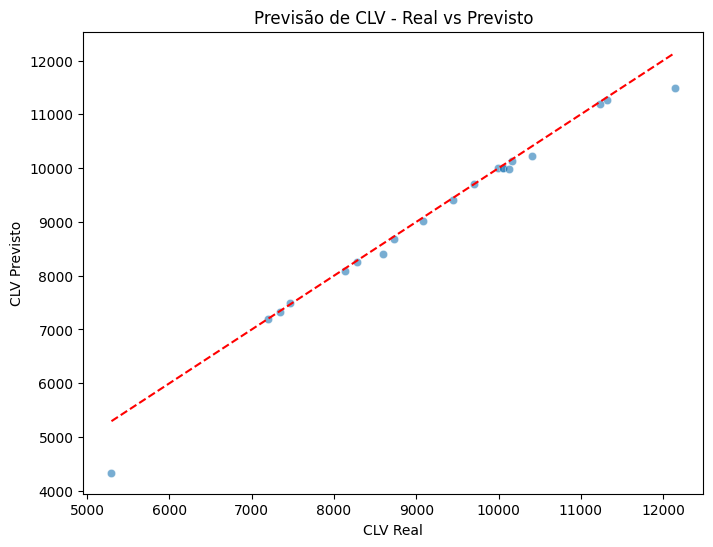

In [0]:
import seaborn as sns

# y_test -> valores reais de CLV
# y_pred -> valores previstos pelo modelo (final_model.predict(X_test))

#Scatter plot (Real vs Previsto)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha referência
plt.xlabel("CLV Real")
plt.ylabel("CLV Previsto")
plt.title("Previsão de CLV - Real vs Previsto")
plt.show()



**14 Nova análise de feature importance**

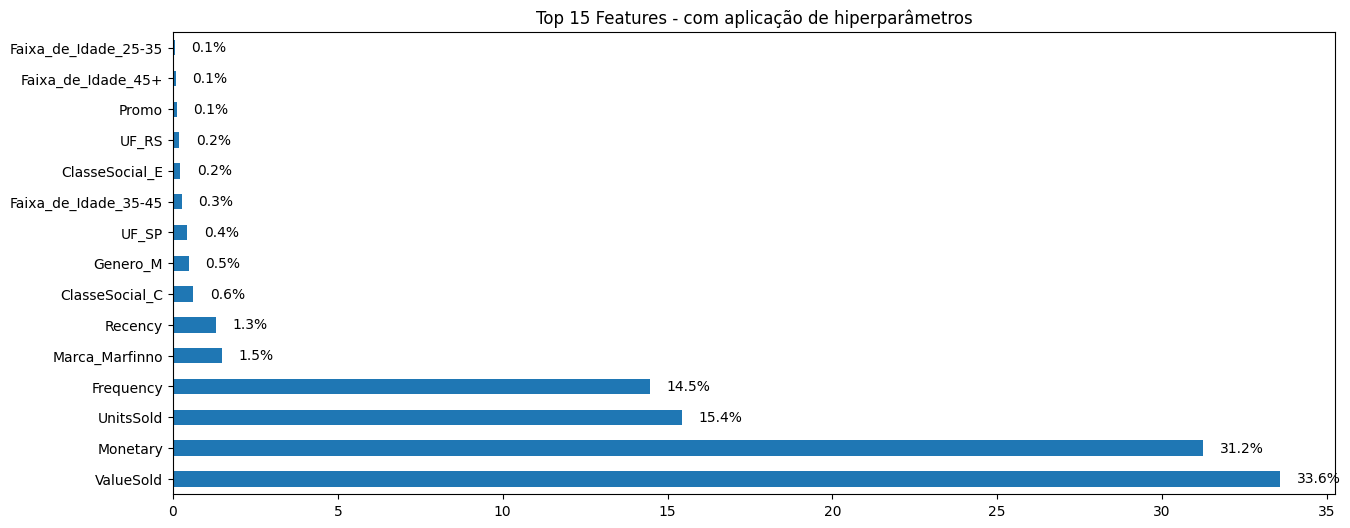

In [0]:

feat_importances_tuning = pd.Series(final_model.feature_importances_, index=X_train.columns)
top15 = feat_importances_tuning.nlargest(15)
top15_pct = (top15 / top15.sum()) * 100 

# Plot do gráfico
ax = top15_pct.plot(kind='barh', figsize=(15,6))
plt.title("Top 15 Features - com aplicação de hiperparâmetros")

# Adiciona os valores ao lado das barras
for i, v in enumerate(top15_pct):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.show()


A análise de importância de variáveis revela um padrão claro: o modelo concentra quase toda a sua capacidade preditiva em fatores transacionais, com destaque para ValueSold (33,6%), Monetary (31,2%), UnitsSold (15,4%) e Frequency (14,5%). Esses quatro indicadores respondem por mais de 90% da explicação, deixando evidente que o comportamento de compra passado é o maior preditor de CLV neste contexto. Essa leitura fornece uma base sólida para priorizar estratégias de marketing que valorizem engajamento de clientes que já compram mais e com maior frequência.

Um achado menos óbvio, mas extremamente relevante, é a baixa contribuição de dados demográficos, promocionais e até mesmo do fator Recency (<2% no total). Isso sugere que idade, gênero ou localização não são decisivos para prever valor futuro — contrariando a expectativa de muitos gestores. Outro ponto técnico importante é a alta correlação esperada entre ValueSold, Monetary e UnitsSold, o que pode levar a uma superestimação da relevância dessas variáveis. Para fortalecer a robustez da análise, recomenda-se complementar com técnicas como SHAP values, importância por permutação e análise de multicolinearidade, garantindo explicações mais confiáveis.

Do ponto de vista estratégico, os resultados abrem caminho para três frentes principais: (1) segmentar clientes por ticket médio e frequência, criando campanhas personalizadas para cada faixa; (2) priorizar retenção de clientes de alto valor, usando modelos de propensão a churn como complemento; e (3) explorar novas features derivadas, como “valor médio por transação” ou “crescimento do gasto ao longo do tempo”, que podem capturar nuances ainda não refletidas no modelo atual. Essas melhorias ampliam tanto a utilidade prática quanto a sofisticação da análise, tornando o estudo mais atrativo e convincente para apresentação em portfólio.